# Iris Classification Problem (Machine Learning)
### Prepared by Marc Anthony B Reyes
December 15, 2018

### Difference between Graph Execution and Eager Execution

In [ ]:
# Graph Execution
# You can't run Graph and Eager Execution at the same time
import tensorflow as tf

tf.InteractiveSession()

a = tf.constant(3)
b = tf.constant(5)

multiply = tf.multiply(a, b)
print(multiply)

multiply.eval() # prints 15

In [1]:
# Eager Execution
# Eager Execution must be executed at program startup
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.12.0
Eager execution: True


### Download the dataset

Download the training dataset file using the ```tf.keras.utils.get_file``` function. This returns the file path of the downloaded file.

In [2]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/marcreyesph/.keras/datasets/iris_training.csv


### Inspect the data
This dataset, ```iris_training.csv```, is a plain text file that stores tabular data formatted as comma- separated values (CSV). Use the ```head -n5``` command to take a peak at the first five entries:

In [3]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


From this view of the dataset, we see the following:
1. The first line is a header containing information about the dataset:
2. There are 120 total examples. Each example has four features and one of three possible label names.
3. Subsequent rows are data records, one example per line, where:
4. The first four fields are **features**: these are characteristics of an example. Here, the fields hold float numbers representing flower measurements.
5. The last column is the **label**: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.

Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

```
0: Iris setosa
1: Iris versicolor
2: Iris virginica```



### Parse the dataset
Since our dataset is a CSV-formatted text file, we'll parse the feature and label values into a format our Python model can use. Each line—or row—in the file is passed to the parse_csv function which grabs the first four feature fields and combines them into a single tensor. Then, the last field is parsed as the label. The function returns both the ```features``` and ```label``` tensors:

In [4]:
def parse_csv(line):
    example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
    parsed_line = tf.decode_csv(line, example_defaults)
    # First 4 fields are features, combine into single tensor
    features = tf.reshape(parsed_line[:-1], shape=(4,))
    # Last field is the label
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

### Create the training tf.data.Dataset

TensorFlow's ```Dataset API``` handles many common cases for feeding data into a model. This is a high-level API for reading data and transforming it into a form used for training. 

This program uses ```tf.data.TextLineDataset``` to load a CSV-formatted text file and is parsed with our ```parse_csv``` function. A ```tf.data.Dataset``` represents an input pipeline as a collection of elements and a series of transformations that act on those elements. Transformation methods are chained together or called sequentially—just make sure to keep a reference to the returned ```Dataset``` object.

Training works best if the examples are in random order. Use ```tf.data.Dataset.shuffle``` to randomize entries, setting ```buffer_size``` to a value larger than the number of examples (120 in this case). To train the model faster, the dataset's ```batch size``` is set to ```32``` examples to train at once.

In [5]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([5.7 3.8 1.7 0.3], shape=(4,), dtype=float32)
example label: tf.Tensor(0, shape=(), dtype=int32)


### Select the type of model

#### Why model?
A model is the relationship between features and the label. For the Iris classification problem, the model defines the relationship between the sepal and petal measurements and the predicted Iris species. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

#### Select the model
We need to select the kind of model to train. There are many types of models and picking a good one takes experience. This tutorial uses a neural network to solve the Iris classification problem. Neural networks can find complex relationships between features and the label. It is a highly-structured graph, organized into one or more hidden layers. Each hidden layer consists of one or more neurons. There are several categories of neural networks and this program uses a dense, or fully-connected neural network: the neurons in one layer receive input connections from every neuron in the previous layer. For example, Figure 2 illustrates a dense neural network consisting of an input layer, two hidden layers, and an output layer:

![A neural network with features, hidden layers, and predictions.](full_network.png "A neural network with features, hidden layers, and predictions.")

When the model from Figure 2 is trained and fed an unlabeled example, it yields three predictions: the likelihood that this flower is the given Iris species. This prediction is called ***inference***. For this example, the sum of the output predictions are 1.0. In Figure 2, this prediction breaks down as: ```0.03``` for Iris setosa, ```0.95``` for Iris versicolor, and ```0.02``` for ***Iris virginica***. This means that the model predicts—with 95% probability—that an unlabeled example flower is an ***Iris versicolor***.

### Create a model using Keras

The TensorFlow ```tf.keras``` API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The ```tf.keras.Sequential``` model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two ```Dense``` layers with 10 nodes each, and an output layer with 3 nodes representing our label predictions. The first layer's ```input_shape``` parameter corresponds to the amount of features from the dataset, and is required.

In [6]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3)
])

The activation function determines the output of a single neuron to the next layer. This is loosely based on how brain neurons are connected. There are many available activations, but ReLU is common for hidden layers.

### Train the model
***Training*** is the stage of machine learning when the model is gradually optimized, or the model learns the dataset. The goal is to learn enough about the structure of the training dataset to make predictions about unseen data. If you learn too much about the training dataset, then the predictions only work for the data it has seen and will not be generalizable. This problem is called ***overfitting***—it's like memorizing the answers instead of understanding how to solve a problem.

The Iris classification problem is an example of ***supervised machine learning***: the model is trained from examples that contain labels. In ***unsupervised machine learning***, the examples don't contain labels. Instead, the model typically finds patterns among the features ***(feature extraction)***.

### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's ***loss**. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the ```tf.losses.sparse_softmax_cross_entropy``` function which takes the model's prediction and the desired label. The returned loss value is progressively larger as the prediction gets worse.

In [7]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

The ```grad``` function uses the ```loss``` function and the ```tf.GradientTape``` to record operations that compute the ***gradients*** used to optimize our model

### Create an optimizer
An optimizer applies the computed gradients to the model's variables to minimize the loss function. You can think of a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

![Optimization algorthims visualized over time in 3D space.](opt1.gif "Optimization algorthims visualized over time in 3D space.")

TensorFlow has many optimization algorithms available for training. This model uses the ```tf.train.GradientDescentOptimizer``` that implements the ***stochastic gradient descent (SGD)*** algorithm. The ```learning_rate``` sets the step size to take for each iteration down the hill. This is a ***hyperparameter*** that you'll commonly adjust to achieve better results.

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each epoch. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training ```Dataset``` grabbing its ```features (x)``` and ```label (y)```.
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an ```optimizer``` to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The ```num_epochs``` variable is the amount of times to loop over the dataset collection. Counter- intuitively, training a model longer does not guarantee a better model. ```num_epochs``` is a hyperparameter that you can tune. Choosing the right number usually requires both experience and experimentation.

In [9]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.330, Accuracy: 10.833%
Epoch 050: Loss: 0.617, Accuracy: 70.000%
Epoch 100: Loss: 0.444, Accuracy: 70.000%
Epoch 150: Loss: 0.406, Accuracy: 71.667%
Epoch 200: Loss: 0.382, Accuracy: 76.667%


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often ***more helpful*** to see this progress. ***TensorBoard*** is a nice visualization tool that is packaged with TensorFlow, but we can create basic charts using the ***matplotlib*** module.

Interpreting these charts takes some experience, but you really want to see the ```loss``` go down and the ```accuracy``` go up.

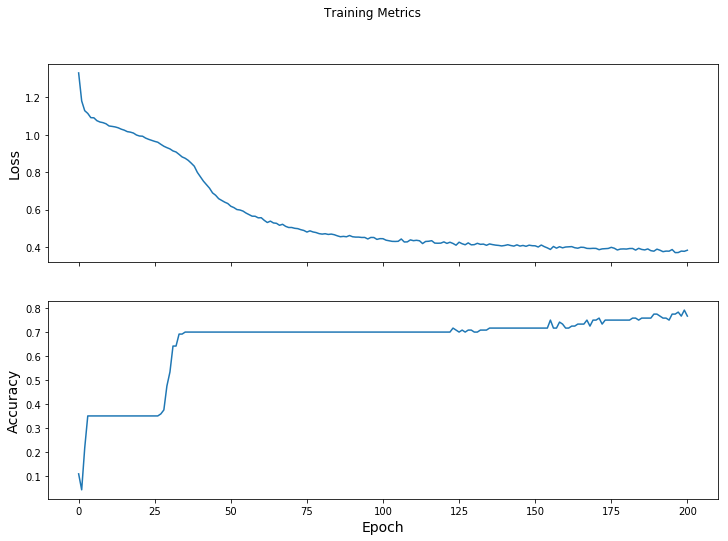

In [10]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

### Setup the test dataset

Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate test set rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The setup for the test ```Dataset``` is similar to the setup for training ```Dataset```. Download the CSV text file and parse that values, then give it a little shuffle:

In [11]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

### Evaluate the model on the test dataset
Unlike the training stage, the model only evaluates a single epoch of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set.

In [12]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 63.333%


### Use the trained model to make predictions

We've trained a model and "proven" that it's good—but not perfect—at classifying Iris species. Now let's use the trained model to make some predictions on unlabeled examples; that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

- ```0:``` Iris setosa
- ```1:``` Iris versicolor
- ```2:``` Iris virginica


In [13]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris virginica
Example 2 prediction: Iris virginica


The predictions look good, yay!